In [3]:
import astropy
from astropy.io import fits
import astropy.units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares

1. Data Acquisition + Data preprocessing 

In [196]:
#importing fits files that have already been downloaded to my computer
fits_files = [
    'tess2018234235059-s0002-0000000100100827-0121-s_lc.fits',
    'tess2018263035959-s0003-0000000100100827-0123-s_lc.fits',
    'tess2020238165205-s0029-0000000100100827-0193-s_lc.fits',
    'tess2020266004630-s0030-0000000100100827-0195-s_lc.fits',
    'tess2023237165326-s0069-0000000100100827-0264-s_lc.fits'
]

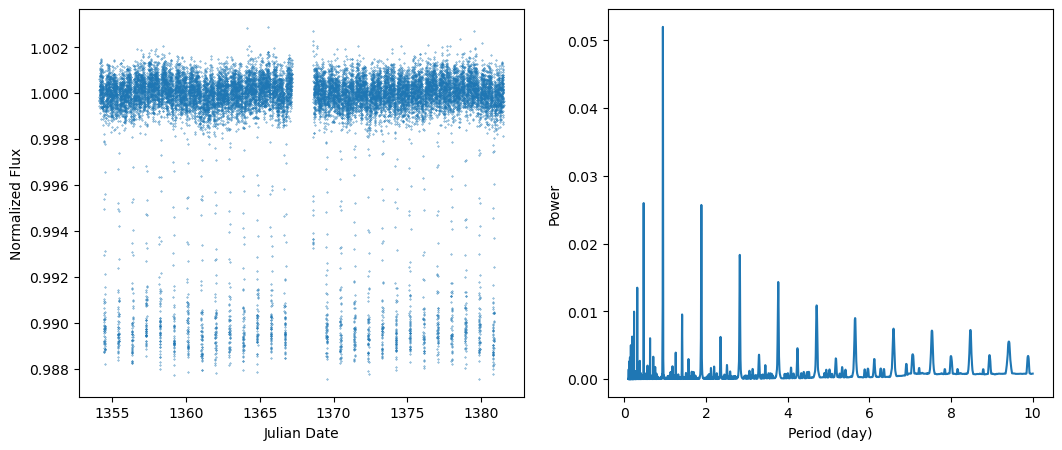

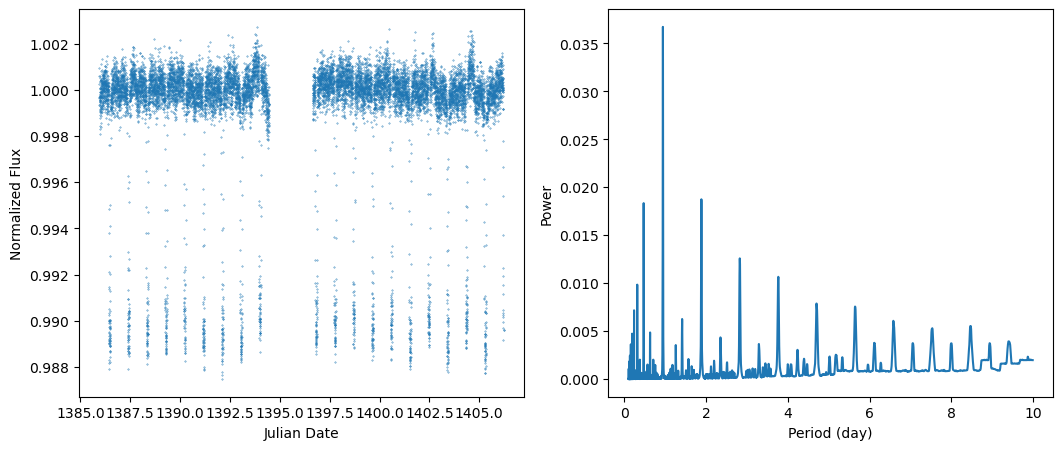

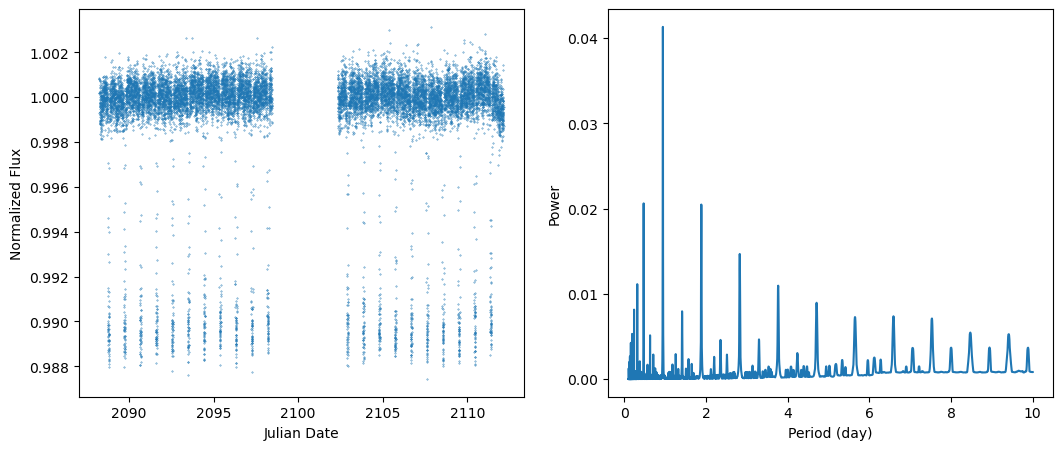

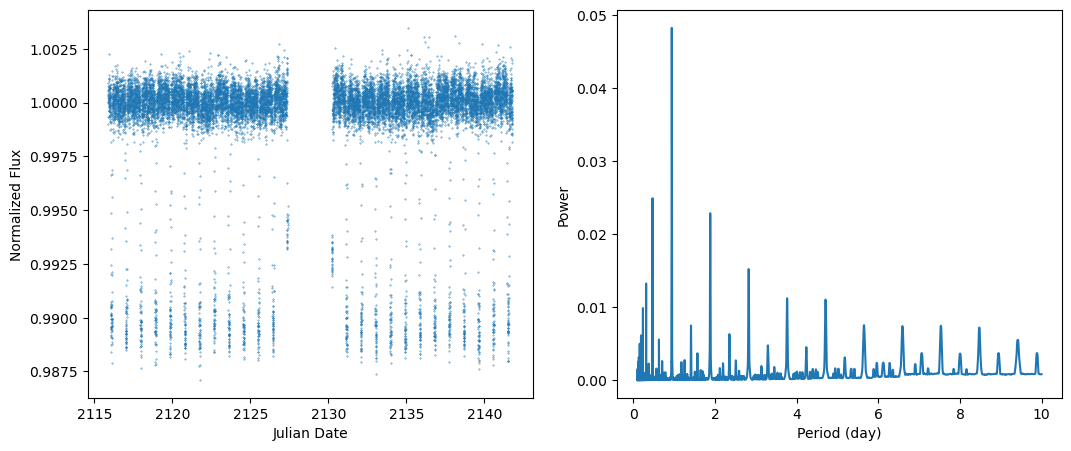

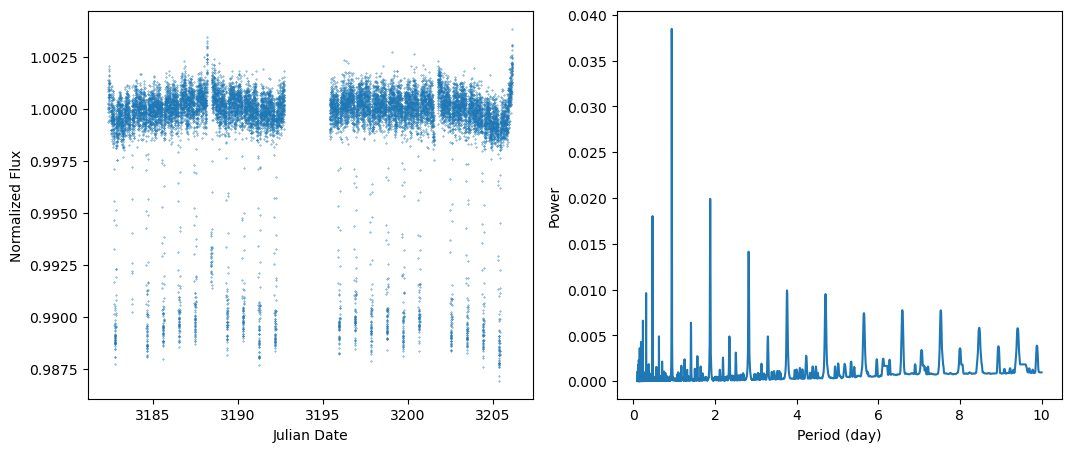

In [198]:
# Lists to store flux and time data
all_flux = []
all_time = []
#lists to store depth, duration, period, epoch and depth error for each sector 
transit_depth_ls = []
transit_duration_ls = []
transit_period_ls = []
transit_depth_err_ls = []
epoch = []

for i, fits_file in enumerate(fits_files):
    hdu_list = fits.open(fits_file, memmap=True)
    data = Table(hdu_list[1].data)

    #cleaning the data
    mask = (data['QUALITY'] == 0) & (~np.isnan(data['PDCSAP_FLUX']))
    data_filtered = data[mask]

    #append time and flux to the respective lists
    current_time = data_filtered['TIME'].tolist()
    current_flux = data_filtered['PDCSAP_FLUX']/(np.median(data_filtered['PDCSAP_FLUX'])).tolist()
    current_flux_error = data_filtered['PDCSAP_FLUX_ERR']/(np.median(data_filtered['PDCSAP_FLUX_ERR'])).tolist()
    all_time.extend(current_time)
    all_flux.extend(current_flux)

    #plot
    figure, ax = plt.subplots(1, 2)
    figure.set_figwidth(11)
    figure.set_figheight(5)
    figure.tight_layout(pad=3.0)

    plt.subplot(1, 2, 2)
    model = BoxLeastSquares(np.array(current_time) * u.day, np.array(current_flux), dy= np.array(current_flux_error))
    periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
    max_power = np.argmax(periodogram.power)
    transit_period_ls.append(periodogram.period[max_power].value)
    transit_depth_ls.append(periodogram.depth[max_power])
    transit_duration_ls.append(periodogram.duration[max_power].value)  
    epoch.append(periodogram.transit_time[max_power].value)
    transit_time = periodogram.transit_time[max_power].value
    period = periodogram.period[max_power].value
    stats = model.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
    transit_depth_err_ls.append(stats['depth'][1])
    
    
    plt.plot(periodogram.period, periodogram.power)
     
    plt.xlabel('Period (day)')
    plt.ylabel('Power')
    plt.subplot(1, 2, 1)
    plt.scatter(current_time, current_flux, s = 0.1)
    plt.xlabel('Julian Date')
    plt.ylabel('Normalized Flux')
    plt.savefig('./images/lc_' + str(i)+ '.png')
    plt.show()
#table containing concatenated data
result_table = Table({'TIME': all_time, 'FLUX': all_flux})


for visualization purposes: 

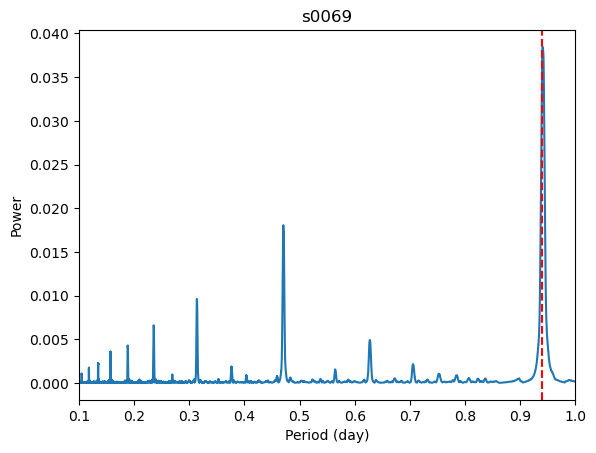

In [199]:
#repeat procedure for file #1 to zoom in on the large spike that shows the period: 
hdu_list = fits.open('tess2018234235059-s0002-0000000100100827-0121-s_lc.fits', memmap=True)
data = Table(hdu_list[1].data)
for i in range(len(data)): 
    new_flux = []
    new_time = []
    new_flux_err = []
    if(data['QUALITY'][i] == 0 and ~np.isnan(data['PDCSAP_FLUX'][i])): 
        new_flux.append(data['PDCSAP_FLUX'][i])
        new_time.append(data['TIME'][i])

model = BoxLeastSquares(np.array(current_time) * u.day, np.array(current_flux), dy=np.array(current_flux_error))
periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
max_power = np.argmax(periodogram.power)  
stats = model.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
plt.plot(periodogram.period, periodogram.power, label = 'Periodogram')
plt.title('s0069')
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.xlim(0.1, 1)
plt.axvline(x=0.94, color='red', linestyle='--', label='Period of 0.94 days')
plt.savefig('./images/period_4.png')

Concatenate lightcurve and produce concatenated periodogram

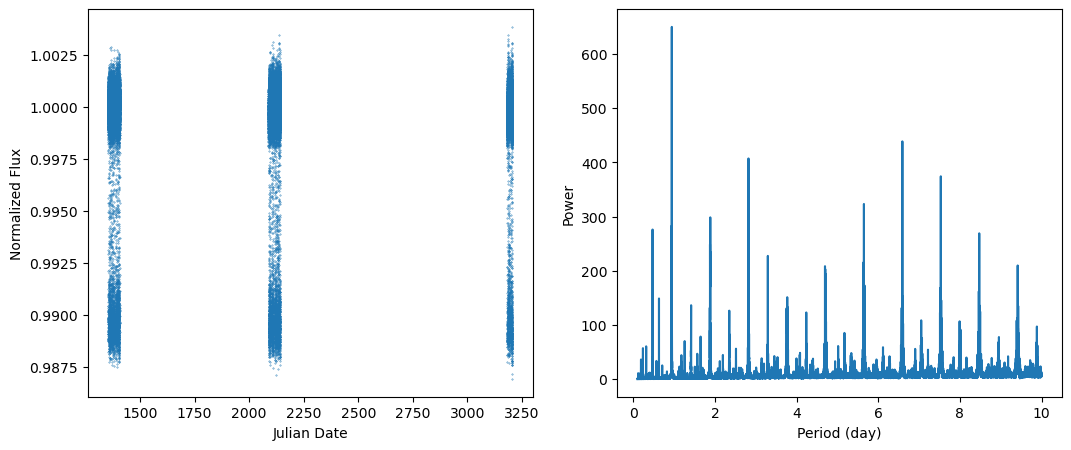

In [200]:
concate_time = np.array([])
concate_flux = np.array([]) 
for i in range(5): 
    #reopening fits files
    data_file = fits.open(fits_files[i], memmap=True)
    #assigning values for ease of manipulation
    time = data_file[1].data['TIME']
    flux = data_file[1].data['PDCSAP_FLUX']
    quality = data_file[1].data['QUALITY']
    #checking for quality 
    new_flux = np.array([])
    new_time = np.array([])
    for j in range(len(time)):
        if(quality[j] == 0 and np.isnan(flux[j]) == False):
            new_flux = np.append(new_flux, flux[j])
            new_time = np.append(new_time, time[j])
    flux_med = np.median(new_flux)
    #normalize flux
    new_flux = new_flux/flux_med
    #append to concatenated lists 
    concate_time = np.append(concate_time, new_time)
    concate_flux = np.append(concate_flux, new_flux)
#apply BLS 
model = BoxLeastSquares(concate_time * u.day, concate_flux, dy=0.01)
period = np.linspace(0.1, 10, 10000) *u.day
periodogram = model.power(period, 0.08)
figure, ax = plt.subplots(1, 2)
figure.set_figwidth(11)
figure.set_figheight(5)
figure.tight_layout(pad=3.0)
plt.subplot(1, 2, 2)
plt.plot(periodogram.period,periodogram.power)
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.subplot(1, 2, 1)
plt.scatter(concate_time, concate_flux, s=0.1)
plt.xlabel('Julian Date')
plt.ylabel('Normalized Flux')
plt.savefig('./images/concate_lc.png')




Calculating statistics by taking the average of the valus in the different sectors

In [202]:
#note that error for all except depth is done by assuming error = 1/value 

transit_depth = 0
transit_duration = 0
transit_period = 0 
transit_time = 0
transit_depth_err = 0
for i in range(len(transit_depth_ls)): 
    transit_depth = transit_depth + transit_depth_ls[i]
    transit_duration = transit_duration + transit_duration_ls[i]
    transit_period = transit_period + transit_period_ls[i]
    transit_time = transit_time + epoch[i]
    transit_depth_err = transit_depth_err + transit_depth_err_ls[i]
transit_depth = transit_depth/len(transit_depth_ls)
transit_duration = transit_duration/len(transit_duration_ls)
transit_period = transit_period/len(transit_period_ls)
transit_time = transit_time/len(epoch)
transit_depth_err = transit_depth_err/len(transit_depth_err_ls)
transit_duration_err = 1/transit_duration
transit_period_err = 1/transit_period
transit_time_err = 1/transit_time
print('transit depth: ', transit_depth, '+/-' , transit_depth_err, '\n', 'transit duration: ', transit_duration,  '+/- ', 1/transit_duration,  '\n', 'transit period: ', transit_period,  '+/- ', 1/transit_period, '\n', 'transit time: ', transit_time,  '+/- ' , 1/transit_time)

transit depth:  0.010387759975312773 +/- 0.03648163637821127 
 transit duration:  0.05 +/-  20.0 
 transit period:  0.9413264300046672 +/-  1.0623307368465602 
 transit time:  2025.7145158390624 +/-  0.0004936529763601928


Radius and impact factor calculations

In [203]:
Rs = 1.319 * u.Rsun #stellar radius
Rs_err = 0.0615 * u.Rsun #stellar radius error
radius_planet = np.sqrt(transit_depth) * Rs
radius_planet_err_radiusp = np.sqrt((0.5 * transit_depth_err/transit_depth)**2 + (Rs_err/Rs)**2)
radius_planet_err = radius_planet * radius_planet_err_radiusp
print('radius of planet: ', radius_planet.to(u.Rearth), '+/-', radius_planet_err.to(u.Rearth))

radius of planet:  14.663458953299353 earthRad +/- 25.757984687312813 earthRad


In [204]:
#calculating impact parameter 
aRs = 3.48 #ratio of semi-major axis to stellar radius
aRs_err = 0.0003 #avg of error boundaries
a = (aRs * Rs)
a_err_a = np.sqrt(((aRs_err/aRs)**2 + (Rs_err/Rs)**2))
a_err = a * a_err_a
#find angle of inclination w/ degree of freedom
cosi = (transit_duration *np.pi)/transit_period - (radius_planet + Rs)/a 
cosi_err1= ((transit_duration * np.pi)/(transit_period))*np.sqrt((transit_duration_err/transit_duration)**2 + (transit_period_err/transit_period)**2)
cosi_err2 = np.sqrt(radius_planet_err.to(u.solRad)**2 + Rs_err**2)
x = (radius_planet.to(u.solRad) + Rs)
cosi_err3 = ((radius_planet.to(u.solRad) + Rs)/a)* np.sqrt((cosi_err2/x)**2 + (a_err/a)**2)
cosi_err = np.sqrt(cosi_err1**2 + cosi_err3**2)
print('a: ', a.to(u.AU), '+/-', a_err.to(u.AU))
print('cosi: ', cosi, '+/-', cosi_err)
b = (a*cosi)/Rs
b_err_num = (a*cosi)* np.sqrt((a_err/a)**2 + (cosi_err/cosi)**2)
num = (a*cosi)
b_err = (a*cosi)/Rs * np.sqrt((b_err_num/num) **2 + (Rs_err/Rs)**2)
# b_err_num = np.sqrt(((a.to(u.Rsun))*cosi)**2 * (a_err/a)**2 + (cosi_err/cosi)**2)
# b_err = np.sqrt(b**2 * (b_err_num/a.to(u.Rsun)*cosi)**2 + (Rs_err/Rs)**2)
print('impact parameter: ', np.abs(b), '+/-', b_err)
print('angle of inc: ' , np.arccos(cosi) * 180/np.pi)

a:  0.021346202783887616 AU +/- 0.0009952947043464317 AU
cosi:  -0.14977325995297455 +/- 66.74849723604231
impact parameter:  0.5212109446363514 +/- -232.28477292396667
angle of inc:  98.61378687439179 rad


3. Phase folding (across 3 transits)

In [205]:
#helps select data across only 3 transits
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [206]:
x = 3*transit_period + epoch[0] - 0.5*transit_period
x = float(x)
time_shifted = []
#lower and upper bounds for the 3 transits
lower_bound = find_nearest(np.array(result_table['TIME']), epoch[0] - 0.5*transit_period)
upper_bound = find_nearest(np.array(result_table['TIME']), x)


In [207]:
#actually selects only 3 transit durations
trimmed_time = []
trimmed_flux = []
for i in range(len(result_table)): 
    if(result_table['TIME'][i] >= lower_bound and result_table['TIME'][i] <= upper_bound): 
        trimmed_time.append(result_table['TIME'][i])
        trimmed_flux.append(result_table['FLUX'][i])

Plotting to confirm: 

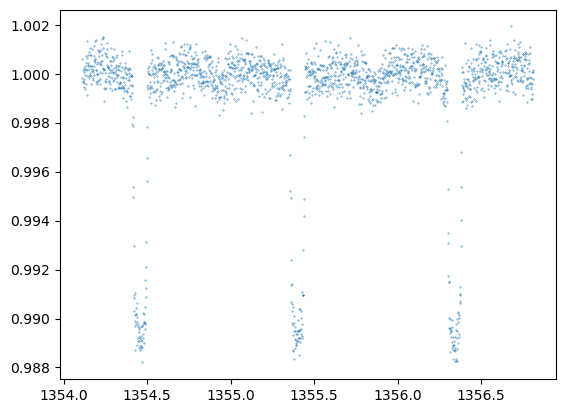

In [208]:
plt.scatter(trimmed_time, trimmed_flux, s=0.1)
plt.savefig('./images/trimmed_lc.png')

Computing the periodogram across these 3 transits for fun (Check to see if period value is still the same)

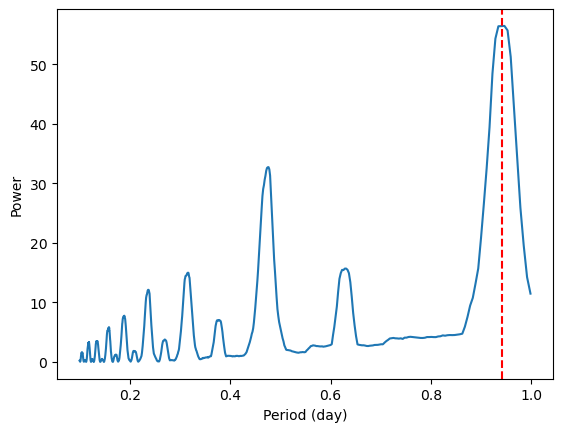

In [209]:
model = BoxLeastSquares(np.array(trimmed_time) * u.day, np.array(trimmed_flux), dy=0.01)
periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=1.0, oversample=1000)
max_power = np.argmax(periodogram.power)
period = periodogram.period[max_power].value
depth = periodogram.depth[max_power]
duration = periodogram.duration[max_power].value 
epoch = periodogram.transit_time[max_power].value
plt.plot(periodogram.period, periodogram.power)
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.axvline(x=0.941, color='red', linestyle='--', label='Period of 0.94 days')
plt.savefig('./images/3_period_periodogram.png')

In [210]:
#phase folding (but not centering)
phase_LS = []
for i in range(len(trimmed_time)): 
    phase = np.mod((trimmed_time[i] - epoch),0.94145223)
    phase_LS.append(phase)

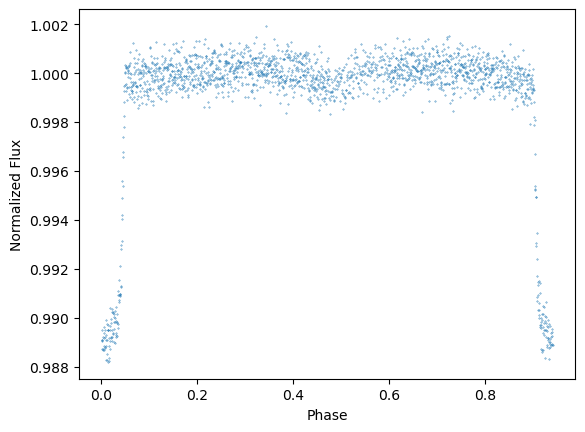

In [211]:
plt.scatter(phase_LS, trimmed_flux, s=0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('./images/Phase_fold_LC_3')

In [212]:
#phase folding AND centering
#value for the period from the NASA exoplanet archive was used because the calculated value wasn't quite accurate to enough 
#sig figs as to not create an issue 
phase_LS = []
for i in range(len(trimmed_time)): 
    #phase[i] = np.mod((concate_time[i] - 2116.0930)-0.94145223/2,0.94145223)
    # used online data.
    phase_LS.append(np.mod((trimmed_time[i] - epoch)-0.94145223/2, 0.94145223))


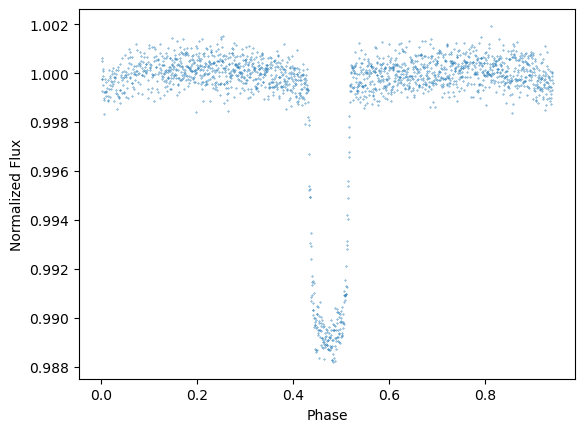

In [213]:
plt.scatter(phase_LS, trimmed_flux, s=0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('Phase_fold_LC_3_centered')
#plt.axvline(x=0.47, color='red', linestyle='--', label='Phase = 0.470')
#plt.legend()
plt.savefig('./images/phase_fold_centered_3.png') 

Phase fold across all transits

In [219]:
phase_LS = []
for i in range(len(result_table['TIME'])): 
    phase = np.mod((result_table['TIME'][i] - transit_time),0.94145223)
    phase_LS.append(phase)
result_table['PHASE'] = phase_LS

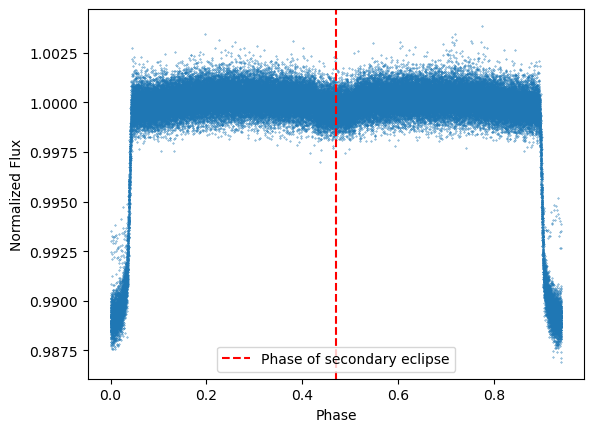

In [220]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s=0.1)
plt.axvline(x=0.47, color='red', linestyle='--', label='Phase of secondary eclipse')
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('./images/phase_fold.png')

In [221]:
phase_LS = []
for i in range(len(result_table['TIME'])):
    phase_LS.append(np.mod((result_table['TIME'][i] - transit_time)-0.94145223/2, 0.94145223))
result_table['PHASE'] = phase_LS

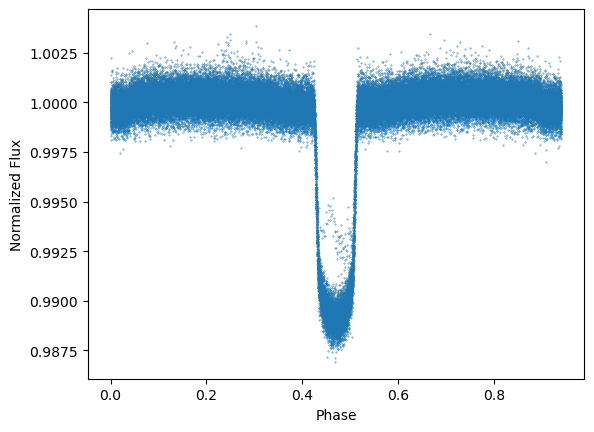

In [222]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s=0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
#plt.axvline(x=0.47, color='red', linestyle='--', label='Phase = 0.47')
plt.savefig('./images/full_phase_fold_centered.png')



In [223]:
sec_phase = np.array([])
sec_flux = np.array([])
for i in range(len(result_table['PHASE'])):
    if result_table['PHASE'][i]<0.1:
        sec_phase = np.append(sec_phase,result_table['PHASE'][i])
        sec_flux = np.append(sec_flux,result_table['FLUX'][i])
    elif 0.85<result_table['PHASE'][i]:
        sec_phase = np.append(sec_phase,result_table['PHASE'][i])
        sec_flux = np.append(sec_flux,result_table['FLUX'][i])
model = BoxLeastSquares(sec_phase, sec_flux, dy=0.01)
periodogram = model.autopower(0.08)
max_power = np.argmax(periodogram.power)
sec_period =periodogram.period[max_power]
sec_time = periodogram.transit_time[max_power]
sec_depth = periodogram.depth[max_power]

In [225]:
stats = model.compute_stats(periodogram.period[max_power],periodogram.duration[max_power],periodogram.transit_time[max_power])
sec_depth_err = stats['depth'][1]
#checking on depth
print('depth: ', sec_depth, '+/-', sec_depth_err)

depth:  0.0003542840103112282 +/- 0.00016192307092022186


Calculating temperature:

In [232]:
Rs = 1.319
Rs_err = Rs_err.value
Ls = 10**0.428
Ls_err = 10**0.0435
radius = radius_planet.value 
Ts = 6432
Ts_err = 48
temp = (sec_depth*(Rs/radius)**2 *Ls)**(1/4) * Ts
error = Rs/radius * (np.sqrt((Rs_err/Rs)**2 + (radius_planet_err.value/radius)**2))
error = sec_depth * (Rs/radius)**2 * Ls * (np.sqrt((sec_depth_err/sec_depth)**2 + (2*error/(Rs/radius))**2 + (Ls_err/Ls)**2))
error = temp * np.sqrt((0.25*error/((sec_depth*(Rs/radius)**2 *Ls)**(1/4)))**2 + (Ts_err/Ts)**2)
print('temp: ', temp, '+/-', error)

temp:  3536.3353897123257 +/- 524.9142327304353


Shifting the graph in order to better display the primary and secondary eclipses

In [233]:
phase_LS = []
for i in range(len(result_table['TIME'])): 
    #phase[i] = np.mod((concate_time[i] - 2116.0930)-0.94145223/2,0.94145223)
    # used online data.
    phase_LS.append(np.mod((result_table['TIME'][i] + 0.25 - epoch)-0.94145223/2, 0.94145223))
result_table['PHASE'] = phase_LS

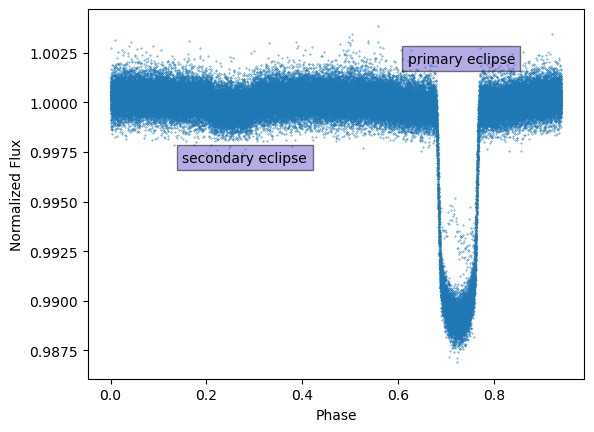

In [234]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s=0.1)
plt.text(0.15,0.997, "secondary eclipse", bbox=dict(facecolor='slateblue', alpha=0.5))
plt.text(0.62,1.002, "primary eclipse", bbox=dict(facecolor='slateblue', alpha=0.5))
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('./images/Full_phase_fold')